This notebook plots the sample completeness functions and redshift distributions as a function of limiting magnitude

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from lbg_survey_metrics.utils import get_completeness
from lbg_survey_metrics.constants import double_col, cmaps
from lbg_survey_metrics.galaxy_distribution import redshift_distribution

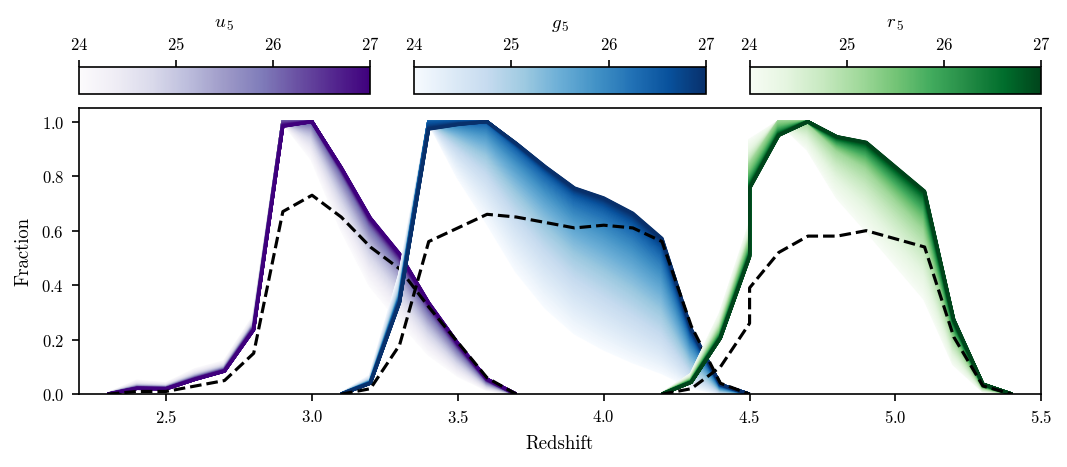

In [2]:
fig, ax = plt.subplots(figsize=double_col, constrained_layout=True, dpi=150)

cbar_pos = [
    [2.2, 1.1, 1, 0.1],
    [3.35, 1.1, 1, 0.1],
    [4.5, 1.1, 1, 0.1]
]
for i, band in enumerate("ugr"):
    # Get redshift distributions for range of limiting magnitudes
    m5 = np.linspace(24, 27, 100)
    z, pz = redshift_distribution(m5, band)

    # create LineCollection
    segments = [np.column_stack([z, p / p.max()]) for p in pz]
    lc = LineCollection(segments, array=m5, cmap=cmaps[band])
    ax.add_collection(lc)

    ax.plot(*get_completeness(band), c="k", ls="--")

    cax = ax.inset_axes(cbar_pos[i], transform=ax.transData)
    cb = fig.colorbar(lc, shrink=0.2, cax=cax, orientation='horizontal')
    cb.ax.xaxis.set_ticks_position("top")
    cb.ax.xaxis.set_label_position("top")
    cb.ax.set_xlabel(f"${band}"+"_{\, 5}$")

ax.set(
    xlim=(2.2, 5.5),
    ylim=(0, 1.05),
    xlabel="Redshift",
    ylabel="Fraction"
)

fig.savefig("figures/pz_and_completeness.pdf")